In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#temp = pd.read_csv('embeddings/250_0.16_vectors.tsv', sep=' ', header=None, skiprows=1)
temp = pd.read_csv("/h/224/stevenhl/chess_dim_skill/src/word2vecf/vectors/size_alpha/vecs_0.16_265.txt", sep=' ', header=None, skiprows=1)
temp = temp.drop(len(temp.columns)-1,axis=1)
#problem_id = list(temp[0])
temp.rename(columns={0:'puzzle_id'}, inplace=True)
temp.set_index('puzzle_id',inplace=True)
temp = temp.divide(np.linalg.norm(temp, axis=1), axis=0)

In [3]:
tag_data = pd.read_csv('/w/225/1/chess/tactics/tactics_problem.csv')
def get_first_tag(row):
    tags = str(row['tags']).split(',')
    return tags[0]

tag_data['tags'] = tag_data.apply(lambda row: get_first_tag(row),axis=1)
#tag_data = tag_data.loc[(tag_data['tags'] != 'nan') & (tag_data['tags'] != 'Mate in 1')]
tag_data = tag_data.loc[(tag_data['tags'] != 'nan')]
#tag_data = tag_data.loc[tag_data['tags'].isna() == False]

In [4]:
shared_puzzles = pd.merge(tag_data,temp,left_on='tactics_problem_id',right_on='puzzle_id')['tactics_problem_id']

In [5]:
#Sample tags and generate distance matrix of those tags
import sklearn.metrics
sample_size=1000
np.random.seed(100)
sampled_problems = np.random.choice(shared_puzzles.values, size = sample_size, replace = False)
def generate_matrix(sampled_problems):
    vecs = temp.loc[sampled_problems]
    cos_sim = sklearn.metrics.pairwise.cosine_similarity(vecs)
    cos_dist = 1.0 - cos_sim
    #Set really small numbers to 0
    cos_dist=cos_dist.round(3)
    #Create cosine distance table
    table = pd.DataFrame(cos_dist, columns=sampled_problems,index=sampled_problems)
    return table

In [6]:
#Generate color pallete
sampled_tags = tag_data.set_index('tactics_problem_id').loc[sampled_problems]['tags']
tag_vals = sampled_tags.unique()
palette = sns.color_palette("hls", len(tag_vals))
lut = dict(zip(tag_vals, palette))
colors = sampled_tags.map(lut)

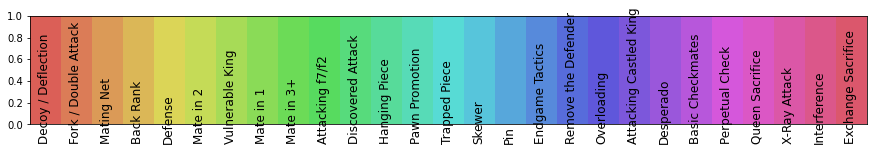

In [7]:
import matplotlib
import matplotlib.pyplot as plt

n=15
size = n/len(tag_vals)
fig = plt.figure(figsize=(n,2))
ax = fig.add_subplot(111)
index = 0
for tag in lut:
    plt.text(index+(size/4), -0.15, tag, fontsize=12,rotation="vertical")
    rect = matplotlib.patches.Rectangle((index,0), size, 2, color=lut[tag])
    ax.add_patch(rect)
    index += size
#ax.set_xticklabels(tag_vals,)
plt.xlim([0, n]) 
plt.tick_params(axis='x',  # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.show()

In [8]:
#Do clustering on condendesed distance matrix
table = generate_matrix(sampled_problems)
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
linkage = hc.linkage(sp.distance.squareform(table), method='complete')

In [9]:
from scipy.cluster.hierarchy import cophenet

cophenet(linkage)[0]

1.06

In [10]:
from operator import itemgetter
from scipy.cluster.hierarchy import fcluster
k=20
cluster = fcluster(linkage, 20, criterion='maxclust')
prob_pair = list(zip(list(sampled_problems), list(cluster)))
prob_pair_sorted = sorted(prob_pair, key=itemgetter(1))

problem_id_grouped = [x[0] for x in prob_pair_sorted]
new_table = generate_matrix(problem_id_grouped)

In [14]:
prob_pair_sorted

[(81063, 1),
 (62544, 1),
 (175999, 1),
 (323569, 1),
 (61577, 1),
 (192779, 1),
 (73421, 1),
 (92803, 1),
 (173334, 1),
 (98877, 1),
 (126347, 1),
 (90860, 1),
 (72422, 1),
 (76651, 1),
 (46972, 1),
 (107488, 1),
 (170285, 1),
 (82964, 1),
 (171459, 1),
 (78862, 1),
 (165878, 1),
 (418063, 1),
 (418931, 2),
 (54617, 2),
 (74381, 2),
 (239507, 2),
 (313337, 2),
 (144576, 3),
 (116058, 3),
 (350811, 3),
 (249887, 3),
 (378401, 3),
 (104487, 3),
 (359939, 3),
 (169226, 3),
 (135411, 3),
 (113282, 3),
 (117542, 3),
 (120922, 3),
 (124629, 3),
 (28494, 3),
 (66215, 3),
 (102491, 3),
 (365365, 4),
 (143867, 4),
 (186864, 4),
 (453373, 4),
 (95041, 4),
 (143770, 4),
 (26755, 4),
 (154590, 4),
 (152988, 4),
 (282805, 4),
 (64402, 4),
 (53916, 4),
 (126656, 4),
 (119196, 4),
 (198375, 4),
 (143078, 4),
 (118017, 4),
 (114323, 4),
 (72377, 4),
 (192033, 4),
 (97123, 4),
 (103660, 4),
 (185593, 4),
 (87398, 4),
 (95325, 4),
 (185163, 4),
 (193270, 4),
 (100585, 4),
 (55200, 4),
 (194718, 4),
 (6

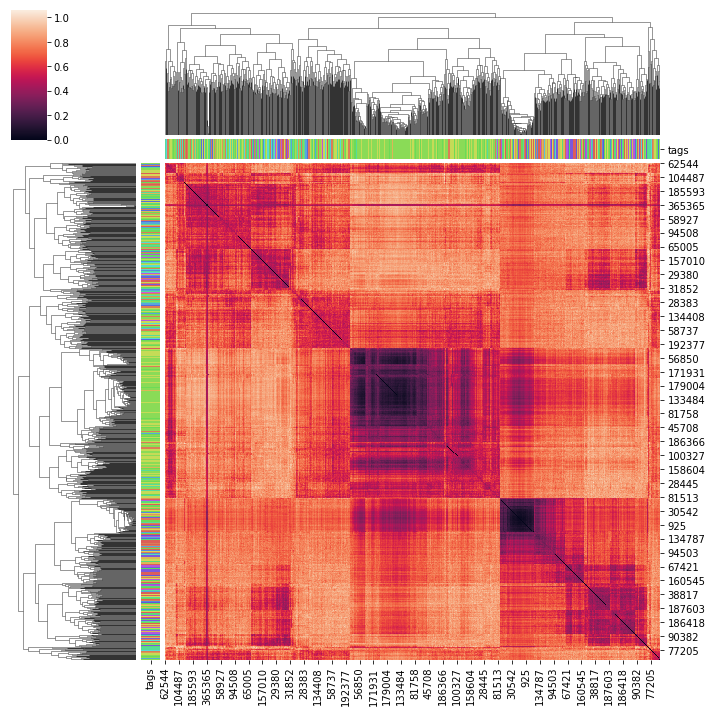

In [16]:
#Set row and column linkage to the clustering genrated above and print heatmap

import seaborn as sns
sns.clustermap(table, row_linkage=linkage, col_linkage=linkage,row_colors=colors,col_colors=colors)

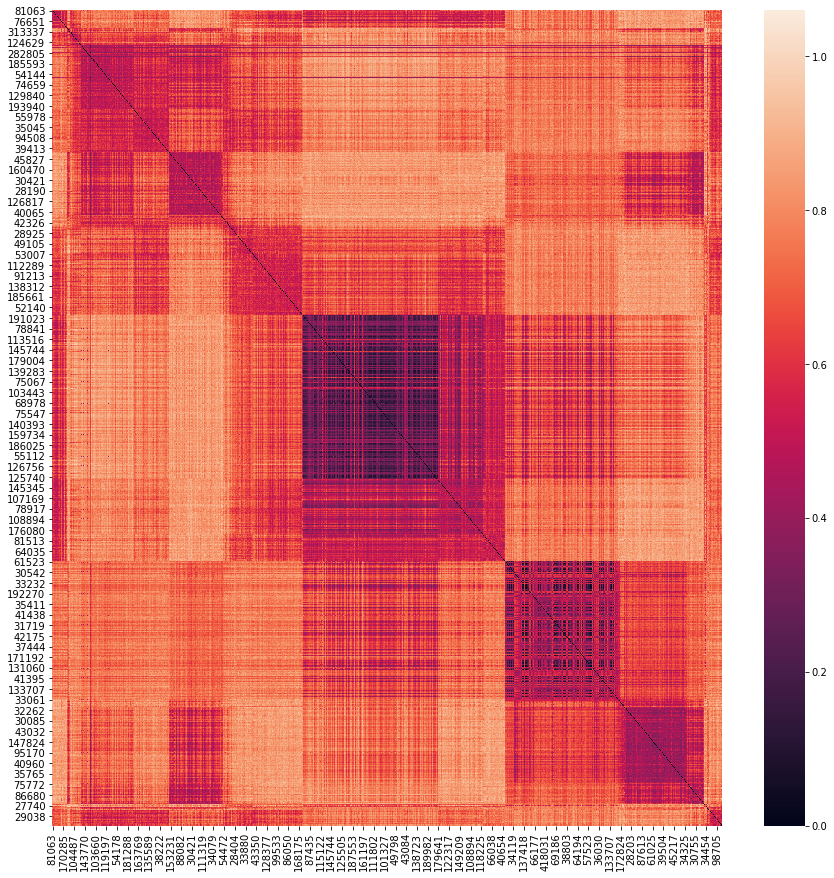

In [17]:
#Heatmap for max no. of clusters = 20

import seaborn as sb
import matplotlib.pyplot as plt
plt.subplots(figsize=(15,15))
sb.heatmap(new_table)

In [18]:
tag_data = pd.read_csv("/h/224/stevenhl/single_tag_data.csv")
puzz_list = list(tag_data['Puzzle ID'])
tag_data

,Puzzle ID,Tag
0,731,Attacking f7/f2
1,732,Basic Checkmates
2,738,Back Rank
3,739,Mate in 3+
4,740,Mate in 3+
...,...,...
54801,661058,Mate in 3+
54802,661060,Hanging Piece
54803,661062,NaN
54804,661064,NaN


In [19]:
cluster_to_tag = {}
for i in range(1,21):
    cluster_to_tag[i] = []


def tag_list(sampled_problems):
    for i in range(len(sampled_problems)):
        cluster_id = prob_pair[i][1]
        pos = puzz_list.index(sampled_problems[i])
        #embedding = list(temp.iloc[pos,:])
        #sampled_problems[i] = embedding
        tag = tag_data.iloc[pos,1]
        cluster_to_tag[cluster_id].append(tag) 
    return cluster_to_tag

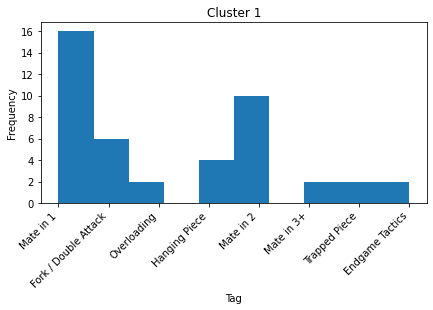

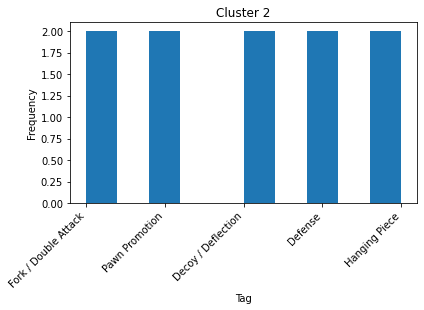

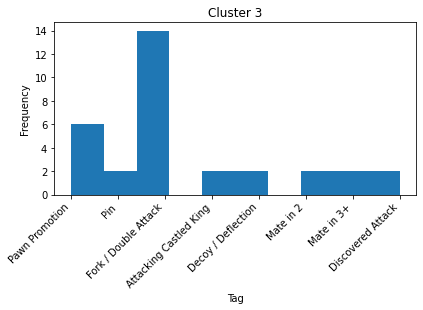

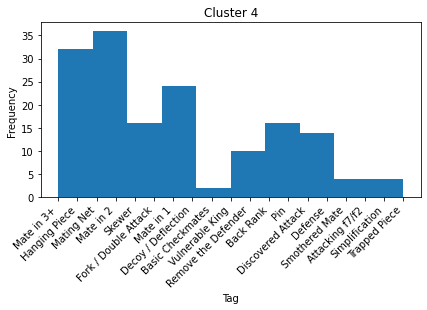

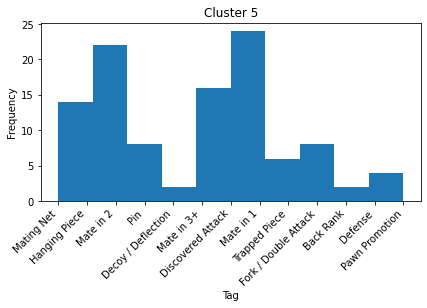

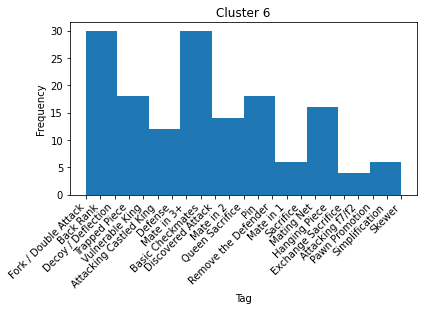

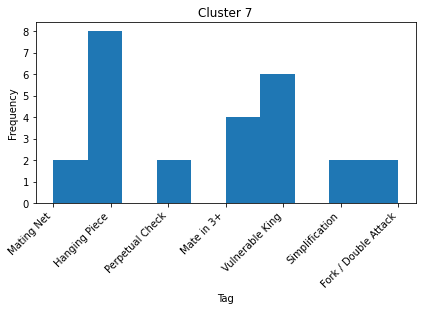

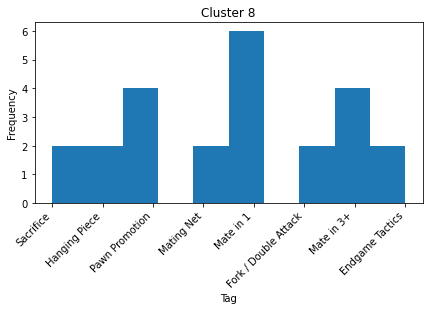

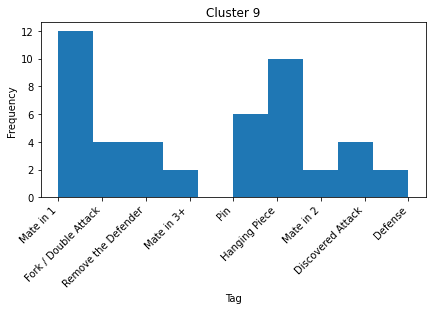

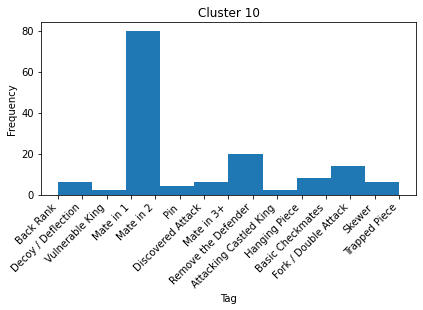

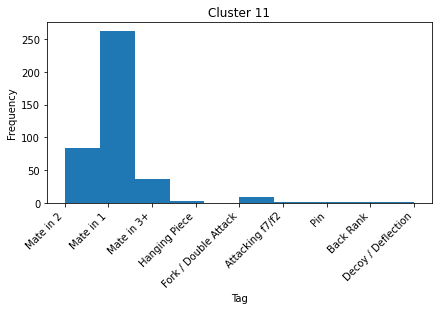

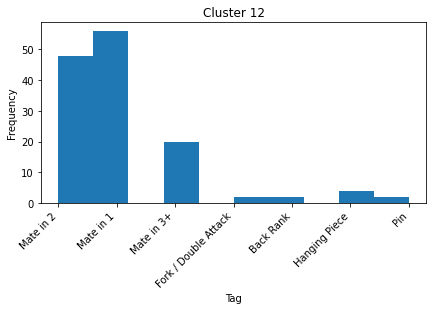

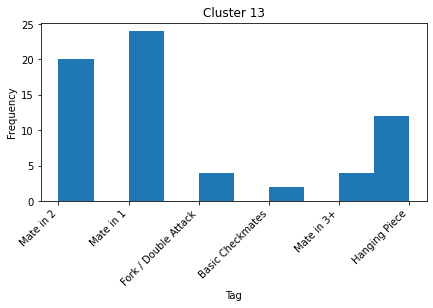

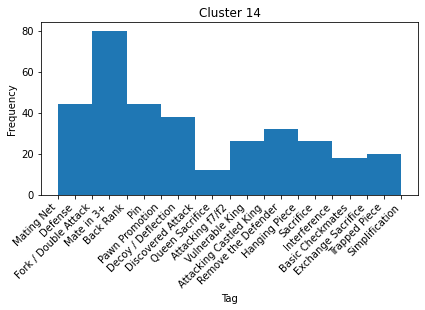

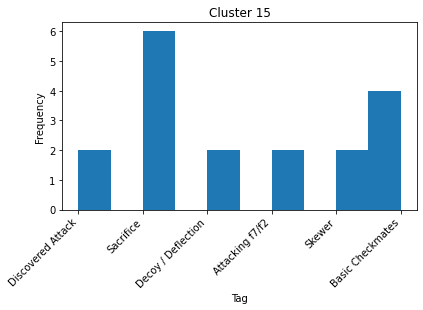

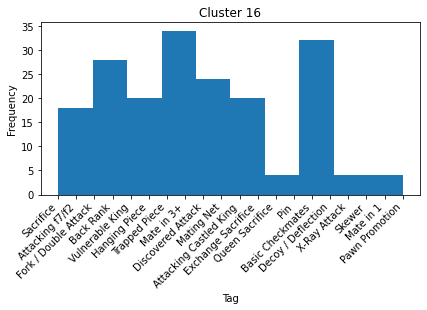

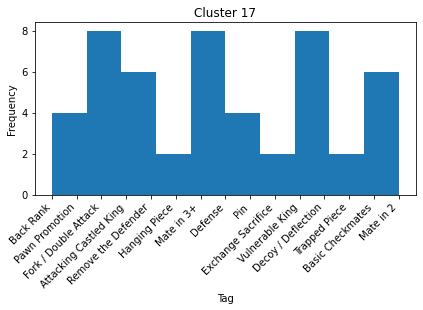

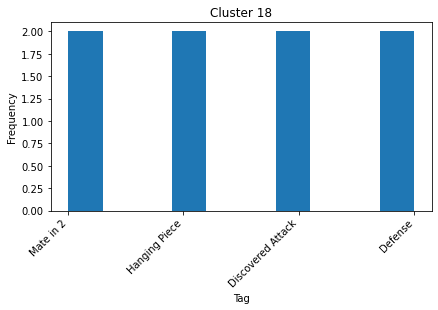

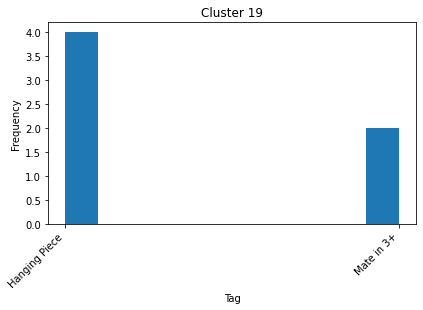

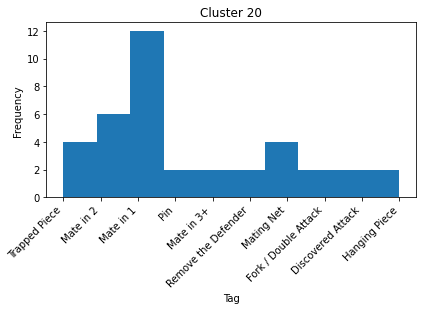

In [23]:
import matplotlib.pyplot as plt

cluster_to_tag = tag_list(sampled_problems)

for i in range(1,21):
    data = cluster_to_tag[i]
    plt.hist(data, bins = 10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.ylabel('Frequency')
    plt.xlabel('Tag')
    title = "Cluster " + str(i)
    plt.title(title)
    plt.savefig("/h/224/stevenhl/Cluster_Tag_Histogram/" + title, bbox_inches = 'tight')
    plt.show()
    plt.clf()
    plt.cla()
    plt.close()

In [21]:
cluster_to_tag[11]

['Mate in 2',
 'Mate in 2',
 'Mate in 2',
 'Mate in 2',
 'Mate in 1',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 1',
 'Mate in 2',
 'Mate in 2',
 'Mate in 2',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 1',
 'Mate in 2',
 'Mate in 2',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 1',
 'Mate in 2',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 2',
 'Hanging Piece',
 'Mate in 2',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 1',
 'Fork / Double Attack',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 3+',
 'Mate in 3+',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 1',
 'Mate in 2',
 'Mate in 1',
 'Mate in 1',
 'Mate in 3+',
 'Mate in 1',
 'Mate in 